In [1]:
import corner
import arviz as az
import matplotlib.pyplot as plt
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [2]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [20]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [6]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]

In [11]:
with pm.Model() as model:
    # evaluate period in log-space
    logP = pm.Normal("logP", mu=np.log(ground_truth["period"]), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # wide prior on t0 to try and help latch onto truth
    t0 = pm.Normal("t0", sd=10, testval=ground_truth["t0"])

    # Kipping (2013) parameterization
    us = xo.distributions.QuadLimbDark("us")

    r = pm.Uniform("r", lower=0.01, upper=0.1)

    # evaluate a in log-space
    loga = pm.Normal("loga", mu=np.log(ground_truth["a"]), sd=0.1)
    a = pm.Deterministic("a", pm.math.exp(loga))

    # create orbit
    # parameterization is largely correlation-free
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, a=a)

    # evaluate light curve, with mean flux of 1
    y = xo.LimbDarkLightCurve(us).get_light_curve(orbit=orbit, r=r, t=t)[:, 0]
    y += 1
    pm.Deterministic("y", y)

    # for error model use basic half-cauchy
    yerr = pm.HalfCauchy("yerr", 0.1)

    # Guassian likelihood
    pm.Normal("obs", mu=y, sd=yerr, observed=flux)

In [12]:
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [yerr, loga, r, us, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 19918.59705863979 -> 112226.9062527568


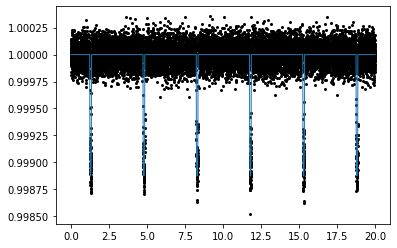

In [13]:
import matplotlib.pyplot as plt
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [14]:
np.random.seed(8462852)
with model:
    trace = pm.sample(
        tune=5000,
        draws=10000,
        step=pm.Metropolis(),
        start=map_soln,
        cores=4,
        chains=4,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [yerr]
>Metropolis: [loga]
>Metropolis: [r]
>Metropolis: [us]
>Metropolis: [t0]
>Metropolis: [logP]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 144 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
trace.to_netcdf(datadir("exoplanet+MH_trace.nc"))
# make sure loads
trace = az.InferenceData.from_netcdf(datadir("exoplanet+MH_trace.nc"))

In [18]:
var_names = ["period", "t0", "r", "a", "us", "yerr"]
with model:
    summary = az.summary(trace, var_names=var_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,3.500,0.000,3.500,3.500,0.000,0.000,1307.0,2662.0,1.0
t0,1.300,0.000,1.300,1.300,0.000,0.000,1325.0,2725.0,1.0
r,0.030,0.000,0.030,0.030,0.000,0.000,924.0,1998.0,1.0
a,10.023,0.030,9.966,10.080,0.001,0.001,703.0,1290.0,1.0
us[0],0.552,0.061,0.436,0.666,0.002,0.002,715.0,965.0,1.0
us[1],0.049,0.107,-0.163,0.239,0.005,0.003,537.0,689.0,1.0
yerr,0.000,0.000,0.000,0.000,0.000,0.000,7816.0,8320.0,1.0


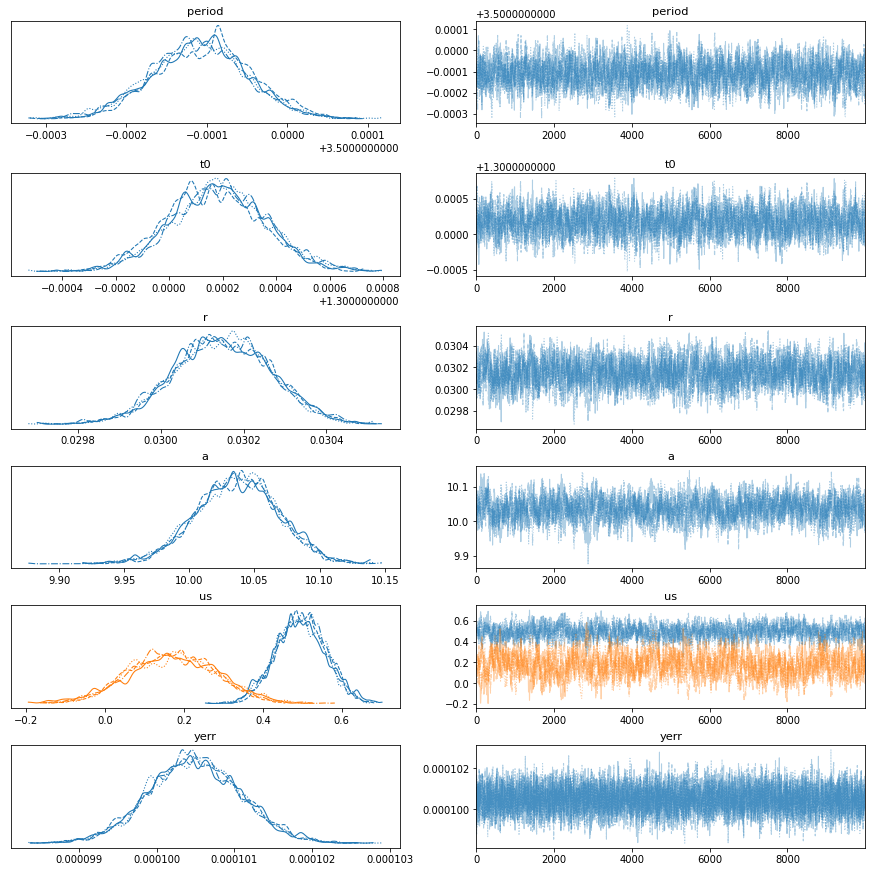

In [35]:
with model:
    az.plot_trace(trace, var_names=var_names);

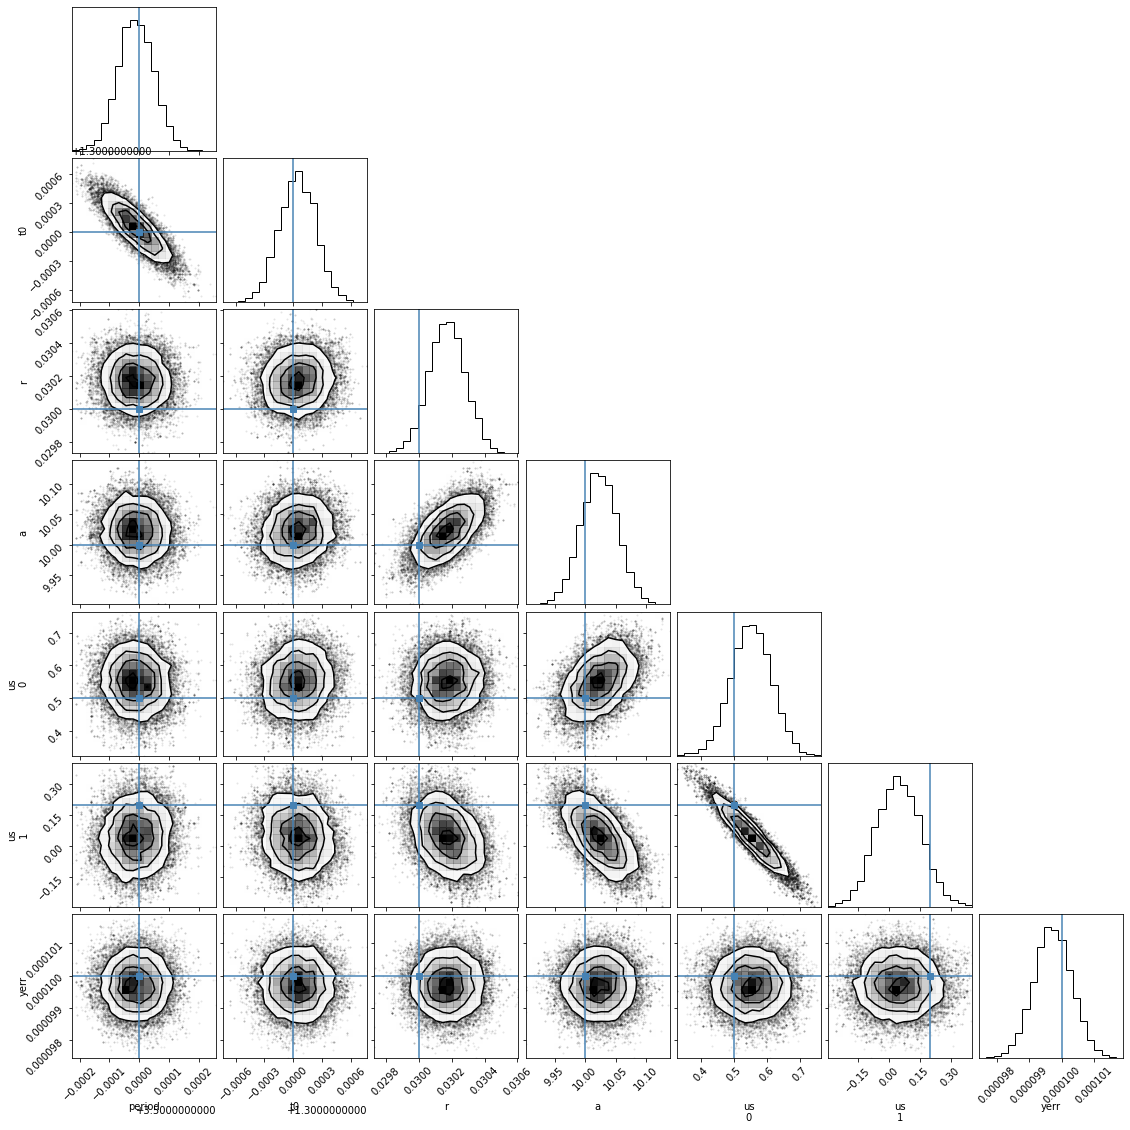

In [22]:
_ = corner.corner(
    trace,
    var_names=var_names,
    truths=ground_truth,
)

In [23]:
# Get the posterior median orbital parameters
p = np.median(trace["posterior"]["period"])
Pmean = np.mean(trace["posterior"]["period"]).values
Pstd = np.std(trace["posterior"]["period"]).values
t0 = np.median(trace["posterior"]["t0"])
pred = trace["posterior"]["y"]
pred = np.median(pred, axis=(0, 1))

In [24]:
true_orbit = xo.orbits.KeplerianOrbit(period=ground_truth["period"], t0=ground_truth["t0"], a=ground_truth["a"])
true_mod = xo.LimbDarkLightCurve(ground_truth["us"]).get_light_curve(orbit=true_orbit, r=ground_truth["r"], t=t)[:, 0].eval() + 1

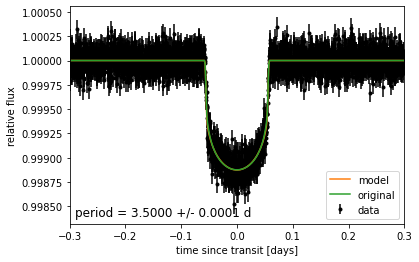

In [25]:
# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(
    x_fold, flux, yerr=1e-4, fmt=".k", label="data", zorder=-1000
)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
plt.plot(x_fold[inds], pred[inds], color="C1", label="model")
plt.plot(x_fold[inds], true_mod[inds], color="C2", label="original")

# Annotate the plot with the planet's period
txt = f"period = {Pmean:.4f} +/- {Pstd:.4f} d"
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.xlim(-0.3, 0.3);

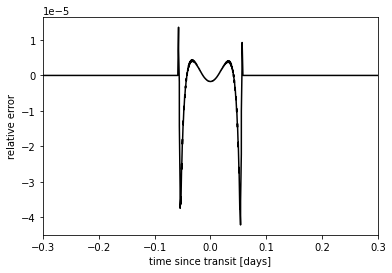

In [26]:
# Plot the folded model residuals
plt.plot(x_fold[inds], pred[inds]/ true_mod[inds] - 1, color="k")
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative error")
plt.xlim(-0.3, 0.3);